In [2]:
import requests
import time
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd


In [183]:
with open('API_key.txt') as f:
    api_key = f.read()

In [ ]:
API_KEY = api_key
BASE_URL = 'http://quickstats.nass.usda.gov/api/api_GET/'
OUTPUT_DIR = 'corn_yield_csv'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Select years for collection
START_YEAR = 1910
END_YEAR = 2024

for year in range(START_YEAR, END_YEAR + 1):
    params = {
        'key': API_KEY,
        'commodity_desc': 'CORN',
        'statisticcat_desc': 'YIELD',
        'unit_desc': 'BU / ACRE',
        'agg_level_desc': 'COUNTY',
        'year': year,
        'format': 'JSON'
    }

    try:
        print(f"Downloading data for year {year}...")
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()

        records = data.get('data', [])
        if not records:
            print(f"No data for {year}, next.")
            continue

        df = pd.DataFrame(records)

        # Salva CSV per l'anno
        csv_path = os.path.join(OUTPUT_DIR, f"corn_yield_{year}_county.csv")
        df.to_csv(csv_path, index=False)
        print(f"Saved {csv_path} with {len(df)} record.")
        time.sleep(3)  

    except requests.exceptions.RequestException as e:
        print(f"Error for year {year}: {e}")
        time.sleep(5)

In [ ]:
INPUT_DIR = 'corn_yield_csv'
OUTPUT_FILE = 'corn_yield_all_years_county.csv'

files = [os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR) if f.endswith('.csv')]
dfs = []

for file in sorted(files):
    print(f"Loading {file}...")
    df = pd.read_csv(file)

    # clean the 'Value' column
    def clean_value(val):
        try:
            return float(str(val).replace(",", ""))
        except:
            return None
    df['Value'] = df['Value'].apply(clean_value)

    dfs.append(df)

if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    full_df.to_csv(OUTPUT_FILE, index=False)
    print(f"Dataset complete saved in '{OUTPUT_FILE}'.")
else:
    print("There are no files to assemble")

Loading corn_yield_csv\corn_yield_1910_county.csv...
Loading corn_yield_csv\corn_yield_1911_county.csv...
Loading corn_yield_csv\corn_yield_1912_county.csv...
Loading corn_yield_csv\corn_yield_1913_county.csv...
Loading corn_yield_csv\corn_yield_1914_county.csv...
Loading corn_yield_csv\corn_yield_1915_county.csv...
Loading corn_yield_csv\corn_yield_1916_county.csv...
Loading corn_yield_csv\corn_yield_1917_county.csv...
Loading corn_yield_csv\corn_yield_1918_county.csv...
Loading corn_yield_csv\corn_yield_1919_county.csv...
Loading corn_yield_csv\corn_yield_1920_county.csv...
Loading corn_yield_csv\corn_yield_1921_county.csv...
Loading corn_yield_csv\corn_yield_1922_county.csv...
Loading corn_yield_csv\corn_yield_1923_county.csv...
Loading corn_yield_csv\corn_yield_1924_county.csv...
Loading corn_yield_csv\corn_yield_1925_county.csv...
Loading corn_yield_csv\corn_yield_1926_county.csv...
Loading corn_yield_csv\corn_yield_1927_county.csv...
Loading corn_yield_csv\corn_yield_1928_county.

In [3]:
df = pd.read_csv('corn_yield_all_years_county.csv')

In [4]:
df.describe()

,region_desc,state_fips_code,country_code,state_ansi,week_ending,county_code,county_ansi,congr_district_code,end_code,begin_code,Value,watershed_desc,watershed_code,CV (%),year,zip_5,asd_code
count,0.0,221557.000000,221557.0,221557.000000,0.0,221557.000000,213879.000000,0.0,221557.0,221557.0,221557.000000,0.0,221557.0,7506.000000,221557.000000,0.0,221557.000000
mean,NaN,30.088032,9000.0,30.088032,NaN,124.446865,93.087353,NaN,0.0,0.0,81.044844,NaN,0.0,5.555622,1978.090415,NaN,49.885844
std,NaN,13.262452,0.0,13.262452,NaN,179.477601,70.645899,NaN,0.0,0.0,48.957053,NaN,0.0,4.511936,25.600817,NaN,25.498104
min,NaN,1.000000,9000.0,1.000000,NaN,1.000000,1.000000,NaN,0.0,0.0,0.000000,NaN,0.0,0.500000,1910.000000,NaN,10.000000
25%,NaN,20.000000,9000.0,20.000000,NaN,41.000000,39.000000,NaN,0.0,0.0,40.000000,NaN,0.0,2.700000,1960.000000,NaN,30.000000
50%,NaN,29.000000,9000.0,29.000000,NaN,87.000000,83.000000,NaN,0.0,0.0,73.600000,NaN,0.0,4.100000,1980.000000,NaN,50.000000
75%,NaN,39.000000,9000.0,39.000000,NaN,139.000000,133.000000,NaN,0.0,0.0,114.600000,NaN,0.0,6.900000,1998.000000,NaN,70.000000
max,NaN,56.000000,9000.0,56.000000,NaN,998.000000,810.000000,NaN,0.0,0.0,296.300000,NaN,0.0,63.400000,2024.000000,NaN,99.000000


In [5]:
df.columns

Index(['source_desc', 'region_desc', 'group_desc', 'agg_level_desc',
       'state_name', 'country_name', 'statisticcat_desc', 'domaincat_desc',
       'state_fips_code', 'country_code', 'sector_desc', 'state_ansi',
       'week_ending', 'county_code', 'prodn_practice_desc', 'county_ansi',
       'reference_period_desc', 'congr_district_code', 'unit_desc', 'end_code',
       'asd_desc', 'load_time', 'begin_code', 'Value', 'domain_desc',
       'util_practice_desc', 'watershed_desc', 'short_desc', 'watershed_code',
       'class_desc', 'commodity_desc', 'freq_desc', 'county_name', 'CV (%)',
       'state_alpha', 'location_desc', 'year', 'zip_5', 'asd_code'],
      dtype='object')

In [6]:
interest_columns = ['year','country_name','state_name','county_name','Value']

In [7]:
df = df.loc[:, interest_columns]

In [8]:
df.isna().sum()

year            0
country_name    0
state_name      0
county_name     0
Value           0
dtype: int64

In [9]:
df['state_name'].unique()

array(['NEBRASKA', 'OHIO', 'MISSOURI', 'NORTH DAKOTA', 'MINNESOTA',
       'SOUTH DAKOTA', 'ILLINOIS', 'NORTH CAROLINA', 'IOWA',
       'WEST VIRGINIA', 'DELAWARE', 'MARYLAND', 'WISCONSIN', 'INDIANA',
       'KENTUCKY', 'OKLAHOMA', 'ALABAMA', 'WASHINGTON', 'MICHIGAN',
       'MONTANA', 'SOUTH CAROLINA', 'MISSISSIPPI', 'NEW JERSEY',
       'GEORGIA', 'TENNESSEE', 'WYOMING', 'NEW MEXICO', 'OREGON',
       'KANSAS', 'VIRGINIA', 'CALIFORNIA', 'LOUISIANA', 'PENNSYLVANIA',
       'ARKANSAS', 'FLORIDA', 'COLORADO', 'ARIZONA', 'TEXAS', 'IDAHO',
       'NEW YORK', 'UTAH'], dtype=object)

In [10]:
# Aggregation for state and year
year_state_mean = df.groupby(['year', 'state_name'])['Value'].mean().reset_index()

In [11]:
# For national average
year_mean = df.groupby(['year'])['Value'].mean().reset_index()

In [12]:
state_year_range = year_state_mean.groupby('state_name')['year'].agg(['min', 'max'])
print(state_year_range)


                 min   max
state_name                
ALABAMA         1939  2024
ARIZONA         1965  2008
ARKANSAS        1961  2024
CALIFORNIA      1959  2023
COLORADO        1963  2024
DELAWARE        1928  2024
FLORIDA         1961  2009
GEORGIA         1954  2024
IDAHO           1972  2024
ILLINOIS        1925  2024
INDIANA         1929  2024
IOWA            1926  2024
KANSAS          1958  2024
KENTUCKY        1929  2024
LOUISIANA       1959  2024
MARYLAND        1928  2024
MICHIGAN        1942  2024
MINNESOTA       1921  2024
MISSISSIPPI     1953  2024
MISSOURI        1919  2024
MONTANA         1944  2016
NEBRASKA        1910  2024
NEW JERSEY      1953  2016
NEW MEXICO      1956  2016
NEW YORK        1972  2024
NORTH CAROLINA  1925  2024
NORTH DAKOTA    1919  2024
OHIO            1918  2024
OKLAHOMA        1933  2024
OREGON          1956  2009
PENNSYLVANIA    1960  2024
SOUTH CAROLINA  1944  2024
SOUTH DAKOTA    1924  2024
TENNESSEE       1955  2024
TEXAS           1968  2024
U

In [13]:
df.head()

,year,country_name,state_name,county_name,Value
0,1910,UNITED STATES,NEBRASKA,BANNER,14.4
1,1910,UNITED STATES,NEBRASKA,BOX BUTTE,16.0
2,1910,UNITED STATES,NEBRASKA,CHEYENNE,9.6
3,1910,UNITED STATES,NEBRASKA,DAWES,16.4
4,1910,UNITED STATES,NEBRASKA,DEUEL,17.5


In [14]:
len(df)

221557

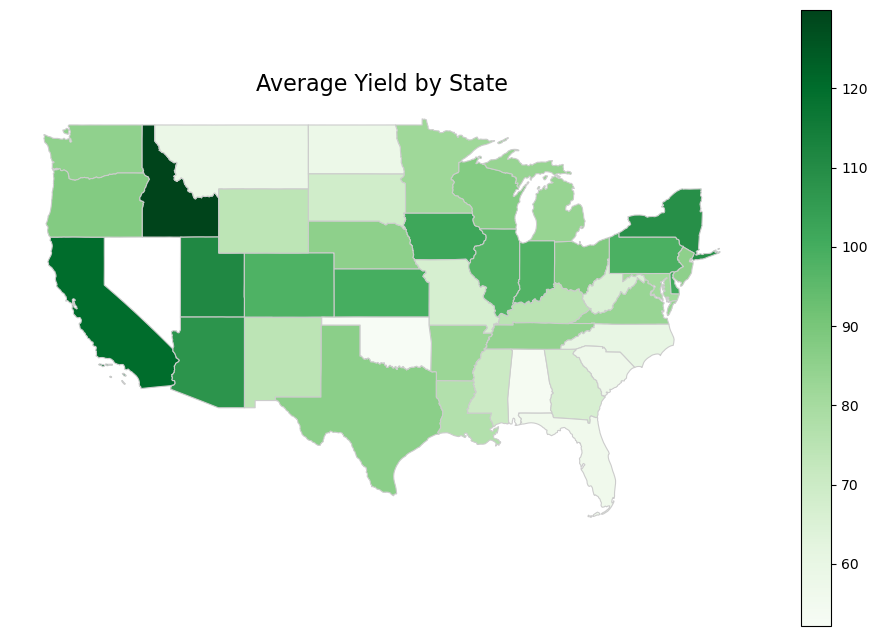

In [15]:
# Group by state to get average yield across all years
state_avg_yield = df.groupby('state_name')['Value'].mean().reset_index()

# Load US state shapefile (download from Census if needed)
states = gpd.read_file("cb_2018_us_state_20m.zip")

# Ensure consistent casing for merge
states['NAME'] = states['NAME'].str.upper()
state_avg_yield['state_name'] = state_avg_yield['state_name'].str.upper()

# Merge data
merged = states.merge(state_avg_yield, left_on='NAME', right_on='state_name')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='Value', cmap='Greens', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
ax.set_title('Average Yield by State', fontsize=16)
ax.axis('off')
plt.show()

In [134]:
df['Value'].describe()

count    221557.000000
mean         81.044844
std          48.957053
min           0.000000
25%          40.000000
50%          73.600000
75%         114.600000
max         296.300000
Name: Value, dtype: float64

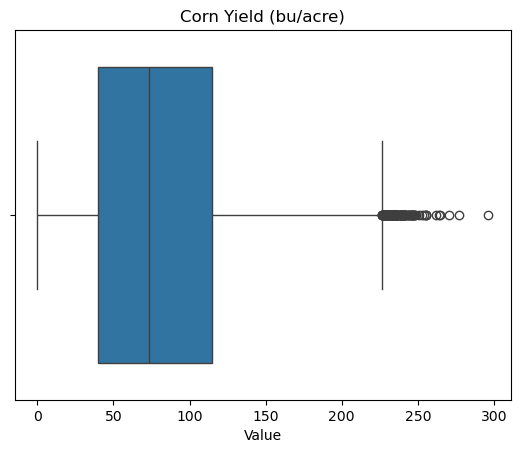

In [17]:
sns.boxplot(df['Value'], orient='h')
plt.title('Corn Yield (bu/acre)')
plt.show()

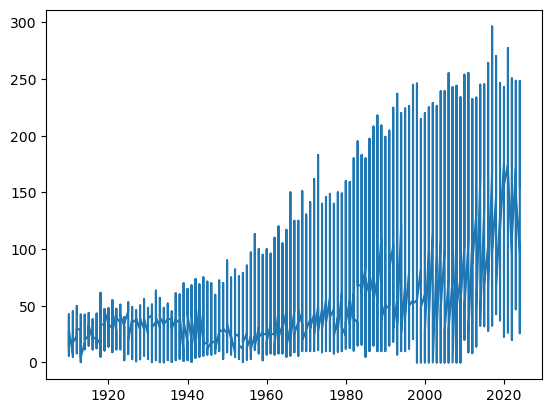

In [18]:
plt.plot(df['year'], df['Value'])
plt.show()

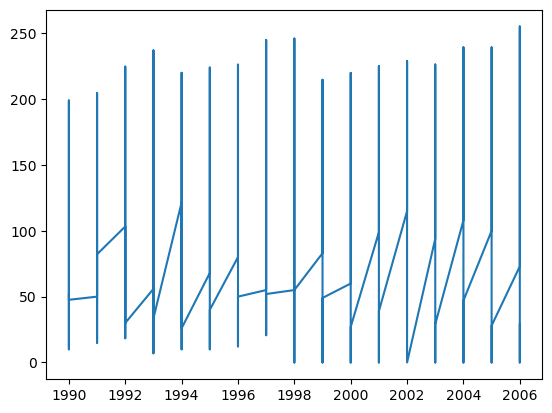

In [19]:
df_filtered = df[(df['year'] >= 1990) & (df['year'] <= 2006)]
plt.plot(df_filtered['year'], df_filtered['Value'])
plt.show()


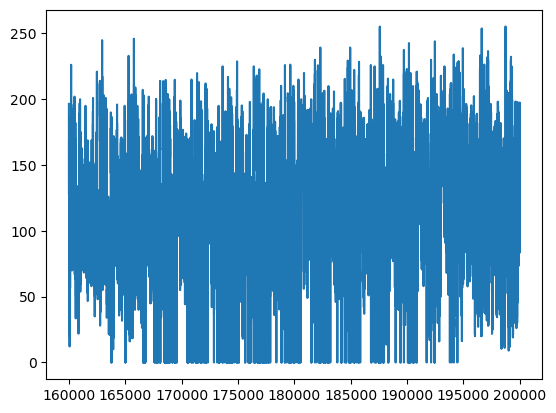

In [20]:
plt.plot(df['Value'].loc[160000:200000])
plt.show()

In [18]:
hist_wx_df = pd.read_parquet('hist_wx_df.parquet')

In [22]:
hist_wx_df.head()

,aoi_id,date,tmax,tmin,precip,swvl1,swvl2,adm2_name,adm1_name
0,USA.14.100_1,2000-01-01,9.146448,-0.300685,0.000000,0.333584,0.316295,Will,Illinois
1,USA.14.100_1,2000-01-02,16.077440,4.774050,0.000000,0.343324,0.317686,Will,Illinois
2,USA.14.100_1,2000-01-03,9.560367,1.645247,0.466668,0.342535,0.320476,Will,Illinois
3,USA.14.100_1,2000-01-04,3.089767,-3.193717,1.183839,0.379731,0.338481,Will,Illinois
4,USA.14.100_1,2000-01-05,-1.597997,-8.902274,0.000000,0.353221,0.343165,Will,Illinois


In [23]:
hist_wx_df.describe().round(2)

,date,tmax,tmin,precip,swvl1,swvl2
count,8527402,8527402.00,8527402.00,8527402.00,8527402.00,8527402.00
mean,2012-03-02 03:27:13.931177984,16.46,6.88,2.36,0.32,0.32
min,2000-01-01 00:00:00,-32.29,-41.80,0.00,0.05,0.06
25%,2006-02-01 00:00:00,7.55,-1.34,0.00,0.27,0.26
50%,2012-03-03 00:00:00,17.97,7.70,0.00,0.34,0.33
75%,2018-04-02 00:00:00,26.25,16.38,1.50,0.38,0.38
max,2024-04-30 00:00:00,44.19,31.56,224.63,0.63,0.63
std,NaN,11.63,11.14,6.34,0.08,0.08


In [24]:
hist_wx_df.isnull().sum()

aoi_id       0
date         0
tmax         0
tmin         0
precip       0
swvl1        0
swvl2        0
adm2_name    0
adm1_name    0
dtype: int64

<Axes: xlabel='tmax'>

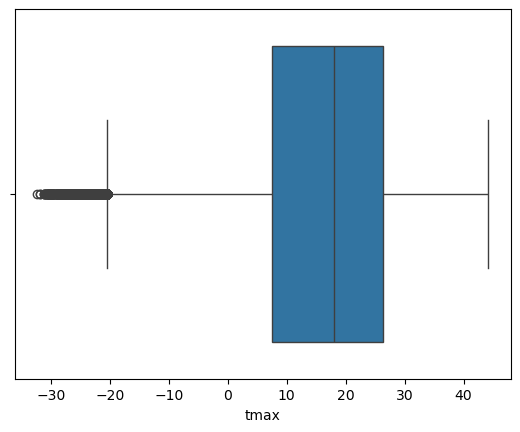

In [ ]:
#sns.boxplot(hist_wx_df['tmax'], orient='h')

<Axes: xlabel='tmin'>

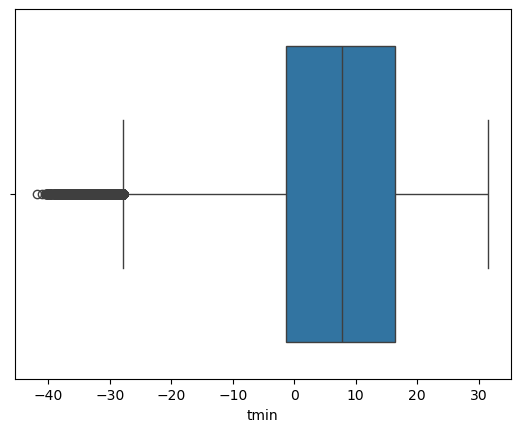

In [26]:
#sns.boxplot(hist_wx_df['tmin'], orient='h')

The box plot you show clearly highlights a common problem in precipitation data:
the presence of very high outliers and a strongly asymmetrical (skewed) distribution because probabily there a lot of days without rain.

In [27]:
#sns.boxplot(hist_wx_df['precip'], orient='h')

In [28]:
#hist_wx_df['precip'].hist(bins=100)
plt.show()

In [29]:
hist_wx_df['rain_flag'] = pd.cut(
    hist_wx_df['precip'],
    bins=[-0.1, 0, 50, float('inf')],
    labels=[0, 1, 2],
    right=True
).astype(int)

In [30]:
#hist_wx_df['rain_flag'].hist()
#plt.show()

In [135]:
ts = year_mean.set_index('year')

In [136]:
ts_yield = pd.Series(ts['Value'])

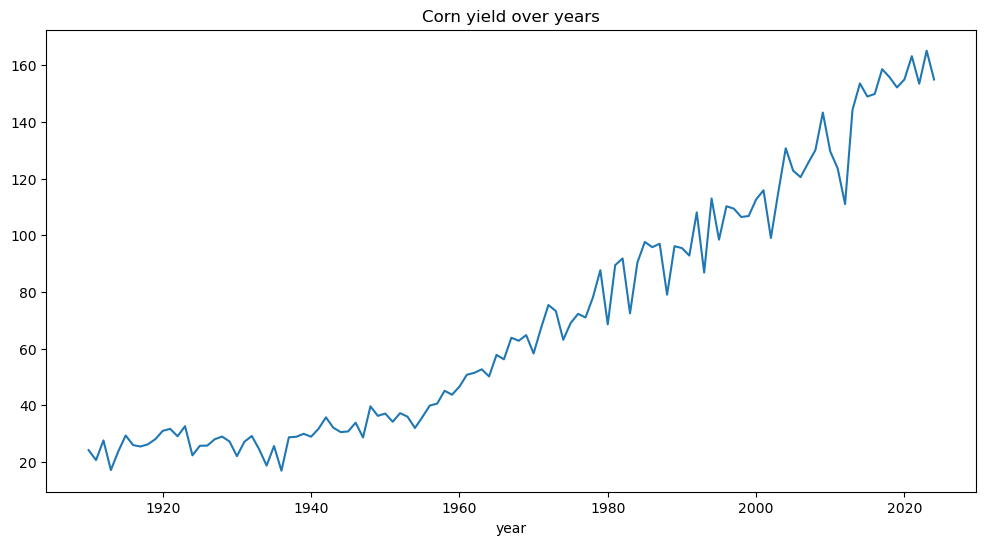

In [137]:
ts_yield.plot(legend=False, title='Corn yield over years', figsize=(12, 6))
plt.show()

In [34]:
state_means = year_state_mean.groupby('state_name')['Value'].mean()

top_state = state_means.idxmax()
bottom_state = state_means.idxmin()


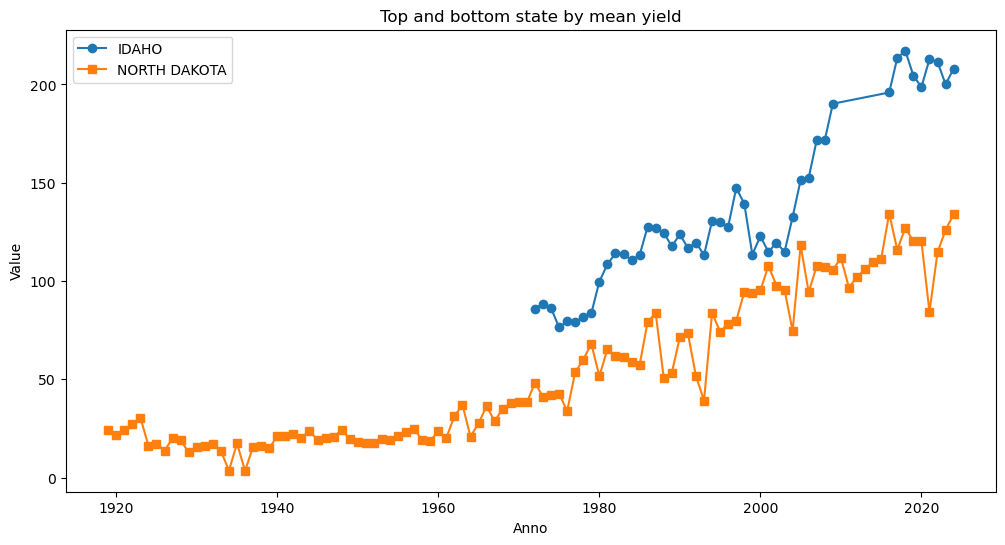

In [35]:
top_data = year_state_mean[year_state_mean['state_name'] == top_state]
bottom_data = year_state_mean[year_state_mean['state_name'] == bottom_state]

plt.figure(figsize=(12, 6))
plt.plot(top_data['year'], top_data['Value'], marker='o', label=top_state)
plt.plot(bottom_data['year'], bottom_data['Value'], marker='s', label=bottom_state)

plt.title("Top and bottom state by mean yield")
plt.xlabel("Anno")
plt.ylabel("Value")
plt.legend()
plt.show()


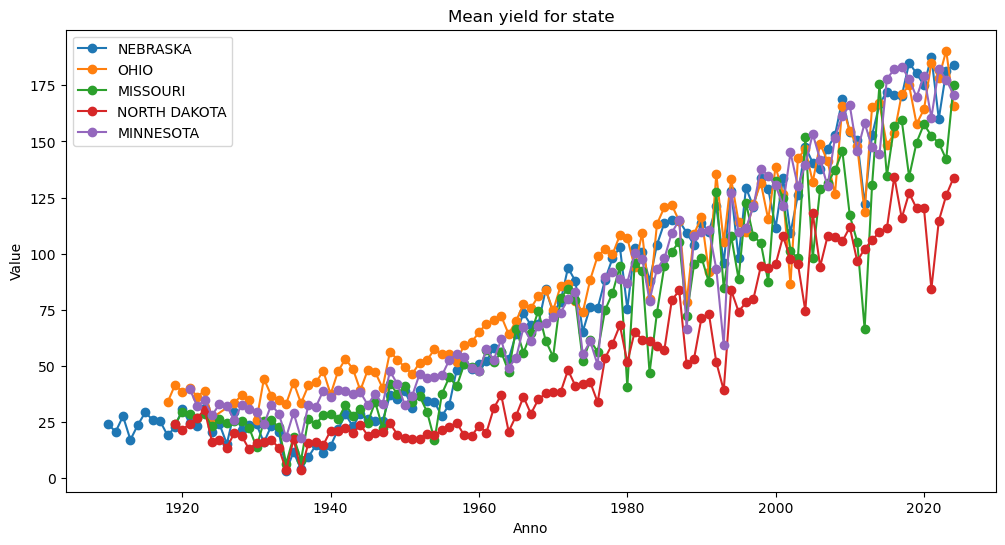

In [36]:
# Graph for the firts 10 states
states_to_plot = year_state_mean['state_name'].unique()[:5]  

plt.figure(figsize=(12, 6))
for state in states_to_plot:
    data = year_state_mean[year_state_mean['state_name'] == state]
    plt.plot(data['year'], data['Value'], marker='o', label=state)

plt.title("Mean yield for state")
plt.xlabel("Anno")
plt.ylabel("Value")
plt.legend()
plt.show()

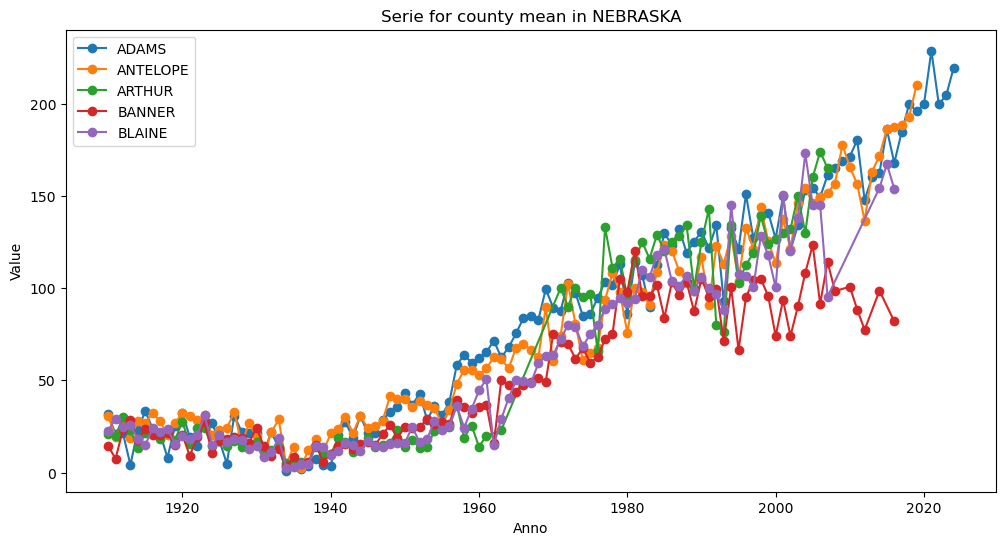

In [37]:
# Serie for county in a specific state
state_example = 'NEBRASKA'
county_time_series = df[df['state_name'] == state_example].groupby(['year', 'county_name'])['Value'].mean().reset_index()

# Selezioniamo alcuni county per il grafico (massimo 5)
counties_to_plot = county_time_series['county_name'].unique()[:5]

plt.figure(figsize=(12, 6))
for county in counties_to_plot:
    data = county_time_series[county_time_series['county_name'] == county]
    plt.plot(data['year'], data['Value'], marker='o', label=county)

plt.title(f"Serie for county mean in {state_example}")
plt.xlabel("Anno")
plt.ylabel("Value")
plt.legend()
plt.show()

## Timeseries

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [39]:
ts = year_mean.set_index('year')
ts_yield = pd.Series(ts['Value'])

In [40]:
ts_yield.isna().sum()

np.int64(0)

In [41]:
ts_yield

year
1910     24.149462
1911     20.627957
1912     27.587097
1913     17.106452
1914     23.718280
           ...    
2020    155.028303
2021    163.246946
2022    153.514138
2023    165.174915
2024    155.005130
Name: Value, Length: 115, dtype: float64

In [42]:
type(ts_yield)

pandas.core.series.Series

In [43]:
ts_yield.index

Index([1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919,
       ...
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      dtype='int64', name='year', length=115)

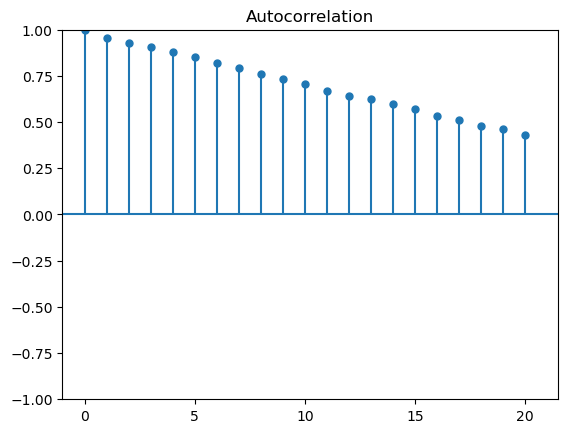

In [44]:
plot_acf(ts_yield.values[11:], lags=20, alpha=1)
plt.show()

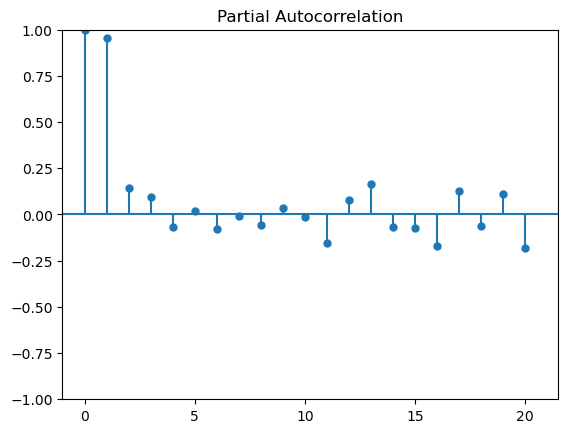

In [45]:
plot_pacf(ts_yield.values[11:], lags=20, alpha=1)
plt.show()

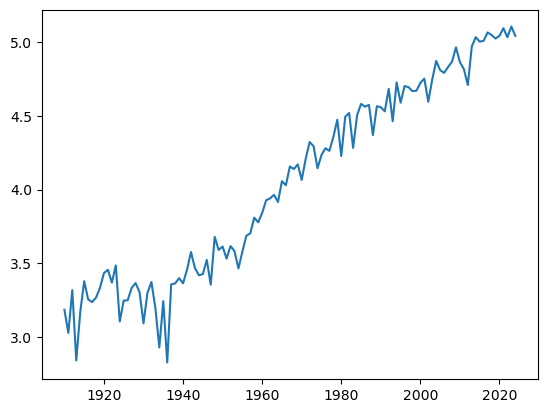

In [46]:
ts_log = pd.Series(np.log(ts_yield))
plt.plot(ts_log)
plt.show()

<Axes: xlabel='year'>

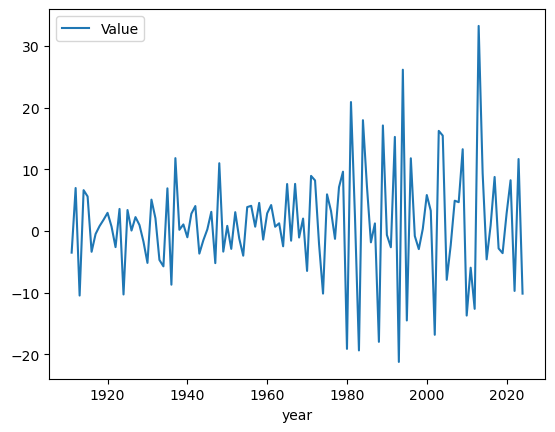

In [47]:
trend = ts.diff() 
trend.plot()


## Weather events

In [48]:
# Ensure datetime format
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])
hist_wx_df['year'] = hist_wx_df['date'].dt.year
hist_wx_df['month'] = hist_wx_df['date'].dt.month

# Filter for growing season (April to October)
growing_season_df = hist_wx_df[hist_wx_df['month'].between(4, 10)]

# Aggregate weather by year
year_weather_summary = growing_season_df.groupby(
    ['year'], 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum=('precip', 'sum'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

In [49]:
growing_season_df

,aoi_id,date,tmax,tmin,precip,swvl1,swvl2,adm2_name,adm1_name,rain_flag,year,month
91,USA.14.100_1,2000-04-01,15.714398,6.749730,0.000000,0.308263,0.322690,Will,Illinois,0,2000,4
92,USA.14.100_1,2000-04-02,14.088400,7.540541,0.000000,0.323923,0.319455,Will,Illinois,0,2000,4
93,USA.14.100_1,2000-04-03,14.387382,8.194945,0.000000,0.331260,0.320314,Will,Illinois,0,2000,4
94,USA.14.100_1,2000-04-04,10.822951,1.983510,0.000000,0.319168,0.318296,Will,Illinois,0,2000,4
95,USA.14.100_1,2000-04-05,15.790977,-2.666101,0.029432,0.310549,0.315423,Will,Illinois,1,2000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8527497,USA.50.9_1,2024-04-26,14.390574,5.418257,0.967823,0.300036,0.309347,Chippewa,Wisconsin,1,2024,4
8527498,USA.50.9_1,2024-04-27,15.066594,8.683216,0.813065,0.370530,0.334744,Chippewa,Wisconsin,1,2024,4
8527499,USA.50.9_1,2024-04-28,13.345714,7.893758,10.281099,0.352298,0.348583,Chippewa,Wisconsin,1,2024,4
8527500,USA.50.9_1,2024-04-29,14.893978,5.650771,7.213643,0.370599,0.371100,Chippewa,Wisconsin,1,2024,4


In [50]:
# Aggregate weather by year
year_state_weather_summary = growing_season_df.groupby(
    ['year', 'adm1_name'], 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum=('precip', 'sum'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

In [51]:
year_state_weather_summary

,year,adm1_name,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
0,2000,Illinois,24.604442,15.020123,65535.670913,0.336009,0.335322
1,2000,Indiana,23.362436,13.952075,60648.897403,0.336135,0.337944
2,2000,Iowa,23.715995,13.574263,53146.954852,0.285794,0.277163
3,2000,Kansas,27.664892,16.325456,44858.689580,0.235809,0.234743
4,2000,Kentucky,25.978824,16.301462,30221.324747,0.359820,0.363367
...,...,...,...,...,...,...,...
320,2024,Nebraska,18.049131,5.801481,6969.781912,0.303635,0.297653
321,2024,Ohio,17.879035,8.071720,9104.181406,0.371049,0.376307
322,2024,South Dakota,15.048102,3.705401,6364.375758,0.359257,0.350737
323,2024,Tennessee,21.729669,12.637080,3716.884228,0.400567,0.406302


In [52]:
year_state_weather_summary['adm1_name'] = year_state_weather_summary['adm1_name'].str.upper()

merged_df_2 = year_state_mean.merge(
    year_state_weather_summary,
    how='inner',
    left_on=['year', 'state_name'],
    right_on=['year', 'adm1_name']
)


In [53]:
merged_df_2

,year,state_name,Value,adm1_name,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
0,2000,ILLINOIS,146.156863,ILLINOIS,24.604442,15.020123,65535.670913,0.336009,0.335322
1,2000,INDIANA,146.150562,INDIANA,23.362436,13.952075,60648.897403,0.336135,0.337944
2,2000,IOWA,143.370707,IOWA,23.715995,13.574263,53146.954852,0.285794,0.277163
3,2000,KANSAS,112.553719,KANSAS,27.664892,16.325456,44858.689580,0.235809,0.234743
4,2000,KENTUCKY,125.126263,KENTUCKY,25.978824,16.301462,30221.324747,0.359820,0.363367
...,...,...,...,...,...,...,...,...,...
320,2024,NEBRASKA,184.237705,NEBRASKA,18.049131,5.801481,6969.781912,0.303635,0.297653
321,2024,OHIO,165.831343,OHIO,17.879035,8.071720,9104.181406,0.371049,0.376307
322,2024,SOUTH DAKOTA,154.871429,SOUTH DAKOTA,15.048102,3.705401,6364.375758,0.359257,0.350737
323,2024,TENNESSEE,133.809756,TENNESSEE,21.729669,12.637080,3716.884228,0.400567,0.406302


In [54]:
merged_df_2['soil_moisture_delta'] = merged_df_2['swvl1_mean'] - merged_df_2['swvl2_mean']
merged_df_2['term_stress'] = merged_df_2['tmax_mean'] - merged_df_2['tmin_mean']
merged_df_2['dry_heat_index'] = (merged_df_2['tmax_mean']) / (merged_df_2['precip_sum'] + 1) # adding one to avoid zero div 

In [55]:
# Variabili climatiche da correlare con la resa
features = ['tmax_mean', 'tmin_mean', 'precip_sum', 'swvl1_mean', 'swvl2_mean', 'dry_heat_index', 'soil_moisture_delta', 'term_stress']

# Funzione per calcolare le correlazioni per uno stato
def compute_correlations(group):
    correlations = {}
    for feature in features:
        correlations[f"corr_{feature}"] = group['Value'].corr(group[feature])
    return pd.Series(correlations)

# Calcola le correlazioni per ogni stato
correlation_df = merged_df_2.groupby('state_name').apply(compute_correlations).reset_index()

# Visualizza il risultato
print(correlation_df)

      state_name  corr_tmax_mean  corr_tmin_mean  corr_precip_sum  \
0       ILLINOIS       -0.376510       -0.294197        -0.004604   
1        INDIANA       -0.336943       -0.250748        -0.197721   
2           IOWA       -0.307612       -0.274980        -0.084464   
3         KANSAS       -0.474227       -0.254801         0.411380   
4       KENTUCKY       -0.320279       -0.172456         0.135039   
5       MICHIGAN       -0.268213       -0.246181        -0.096203   
6      MINNESOTA       -0.066928       -0.060809         0.098144   
7       MISSOURI       -0.499027       -0.386276         0.110422   
8       NEBRASKA       -0.380835       -0.292271         0.154631   
9           OHIO       -0.199480       -0.065540        -0.069020   
10  SOUTH DAKOTA       -0.467838       -0.379307         0.187002   
11     TENNESSEE       -0.206239       -0.041345         0.355266   
12     WISCONSIN       -0.138485       -0.096677         0.059911   

    corr_swvl1_mean  corr_swvl2_m

/tmp/ipykernel_1635090/1733884016.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_df = merged_df_2.groupby('state_name').apply(compute_correlations).reset_index()


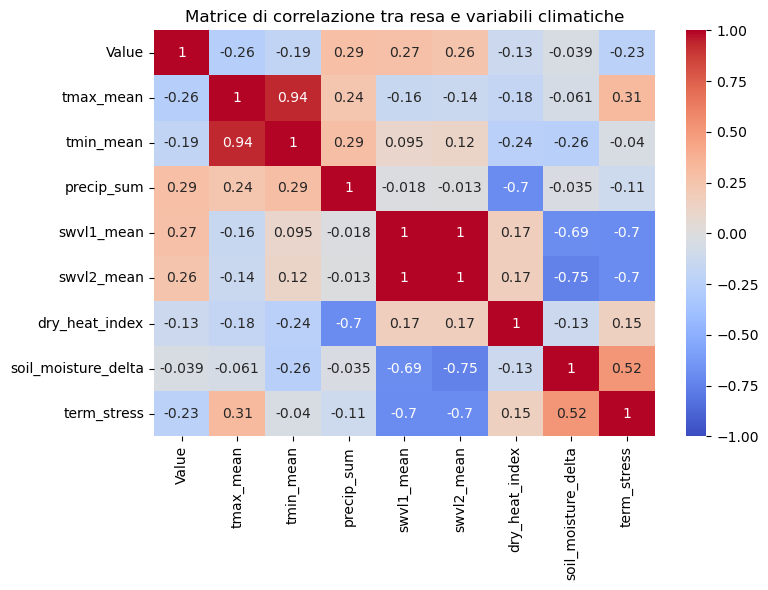

In [56]:
# Calcolo delle correlazioni sull'intero dataset
corr_matrix = merged_df_2[['Value', 'tmax_mean', 'tmin_mean', 'precip_sum', 'swvl1_mean', 'swvl2_mean', 'dry_heat_index', 'soil_moisture_delta', 'term_stress']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice di correlazione tra resa e variabili climatiche")
plt.tight_layout()
plt.show()

In [57]:
year_weather_summary['soil_moisture_delta'] = year_weather_summary['swvl1_mean'] - year_weather_summary['swvl2_mean']
year_weather_summary['term_stress'] = year_weather_summary['tmax_mean'] - year_weather_summary['tmin_mean']
year_weather_summary['dry_heat_index'] = (year_weather_summary['tmax_mean']) / (year_weather_summary['precip_sum'] + 1) # adding one to avoid zero div 

In [58]:
year_weather_summary = year_weather_summary[:-1] # Removing 2024 since the data is not complete

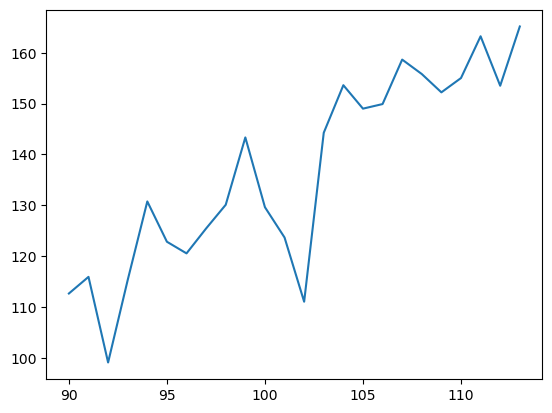

In [59]:
year_mean[(year_mean['year'] >= 2000) & (year_mean['year'] <= 2023)]['Value'].plot()
plt.show()

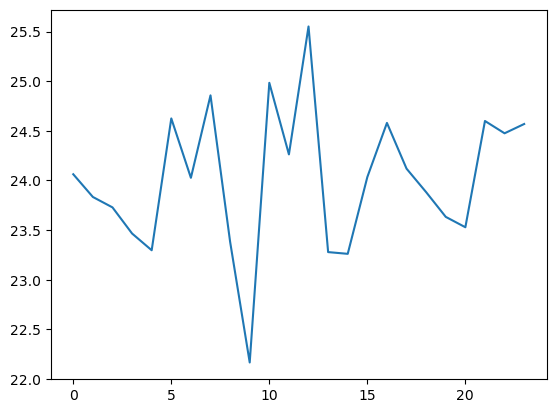

In [60]:
year_weather_summary['tmax_mean'].plot()
plt.show()

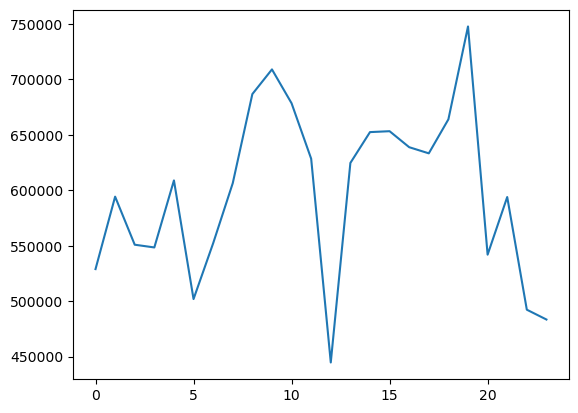

In [61]:
year_weather_summary['precip_sum'].plot()
plt.show()

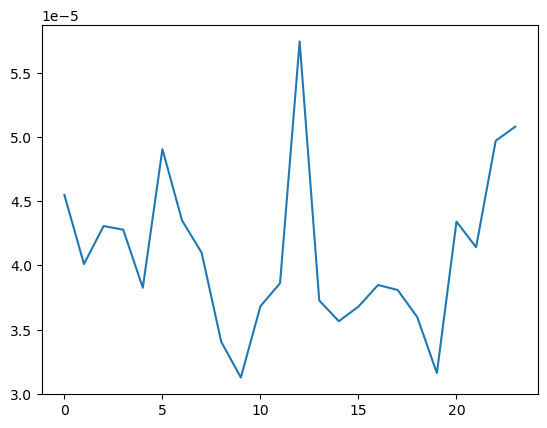

In [62]:
year_weather_summary['dry_heat_index'].plot()
plt.show()

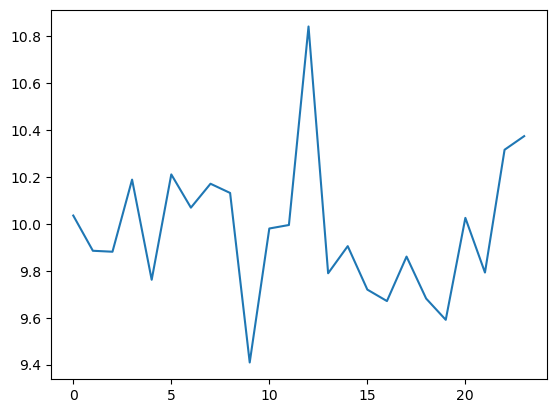

In [63]:
year_weather_summary['term_stress'].plot()
plt.show()

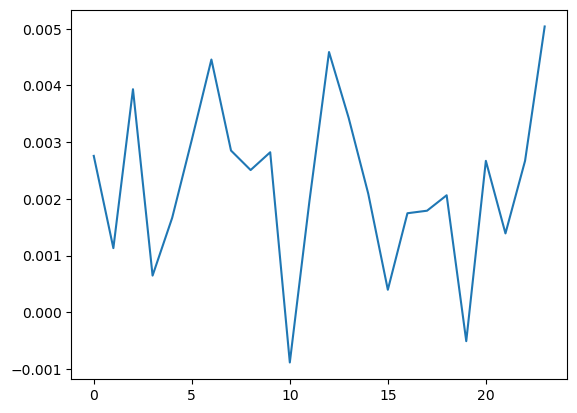

In [64]:
year_weather_summary['soil_moisture_delta'].plot()
plt.show()

By closely analysing the weather data and yield for the period 2000-2023 (range provided for weather data), several things can be noted: <br>
- A sharp decrease in yield around 2012;<br>
- The decrease in yield coincides with a drastic drop in total rainfall; <br>
- Predictably, in addition to the decrease in rainfall, soil moisture also decreased. <br>
- During the same period, it can be observed that the average maximum temperatures were the highest (drought). <br>
- Average maximum temperatures around 25 degrees, combined with good rainfall/soil moisture, allowed for the best yields. <br>

In [65]:
# Aggregate weather by year
weather_summary = growing_season_df.groupby(
    ['year','adm1_name'] 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum=('precip', 'sum'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

In [66]:
weather_summary.sort_values("tmax_mean", ascending=False).head(5)

,year,adm1_name,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
141,2010,Tennessee,28.882612,18.732632,23181.798953,0.319474,0.321904
159,2012,Kansas,28.790511,16.786854,36150.980088,0.208866,0.210051
102,2007,Tennessee,28.620336,18.294796,17649.535423,0.298461,0.295478
146,2011,Kansas,28.459005,16.418536,44025.323462,0.213172,0.213226
289,2022,Kansas,28.409217,16.363027,42373.693255,0.216522,0.215931


In [67]:
weather_summary.sort_values("precip_sum", ascending=False).head(5)

,year,adm1_name,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
117,2009,Illinois,22.859154,13.993028,92829.773538,0.356875,0.358471
132,2010,Iowa,23.799127,14.181634,92020.647862,0.336306,0.340099
236,2018,Iowa,23.009873,13.255383,85797.373769,0.331853,0.332346
106,2008,Iowa,22.295089,12.362914,85322.648265,0.311979,0.308119
247,2019,Illinois,24.784493,15.486605,83213.326774,0.353195,0.354459


In [68]:
merged_df = year_mean.merge(
    year_weather_summary,
    how='inner',
    left_on=['year'],
    right_on=['year']
)


In [70]:
corr = merged_df[['Value', 'tmax_mean', 'tmin_mean', 'precip_sum', 'swvl1_mean', 'swvl2_mean', 'term_stress', 'dry_heat_index', 'soil_moisture_delta' ]].corr()
styled_corr = corr.style.background_gradient(cmap='coolwarm').format(precision=2)
display(styled_corr)


,Value,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean,term_stress,dry_heat_index,soil_moisture_delta
Value,1.00,-0.10,0.04,0.30,0.34,0.34,-0.34,-0.27,-0.17
tmax_mean,-0.10,1.00,0.92,-0.49,-0.65,-0.62,0.63,0.64,0.09
tmin_mean,0.04,0.92,1.00,-0.20,-0.33,-0.30,0.26,0.35,-0.14
precip_sum,0.30,-0.49,-0.20,1.00,0.87,0.87,-0.79,-0.97,-0.64
swvl1_mean,0.34,-0.65,-0.33,0.87,1.00,1.00,-0.91,-0.91,-0.62
swvl2_mean,0.34,-0.62,-0.30,0.87,1.00,1.00,-0.90,-0.91,-0.67
term_stress,-0.34,0.63,0.26,-0.79,-0.91,-0.90,1.00,0.86,0.49
dry_heat_index,-0.27,0.64,0.35,-0.97,-0.91,-0.91,0.86,1.00,0.59
soil_moisture_delta,-0.17,0.09,-0.14,-0.64,-0.62,-0.67,0.49,0.59,1.00


Corn yield shows a positive relationship with water availability (rain and soil moisture) and a negative relationship with high temperatures, especially maximum temperatures.  <br>
This suggests that crops respond well to a temperate and humid climate, while excessive heat can penalise them, a classic effect of heat stress.

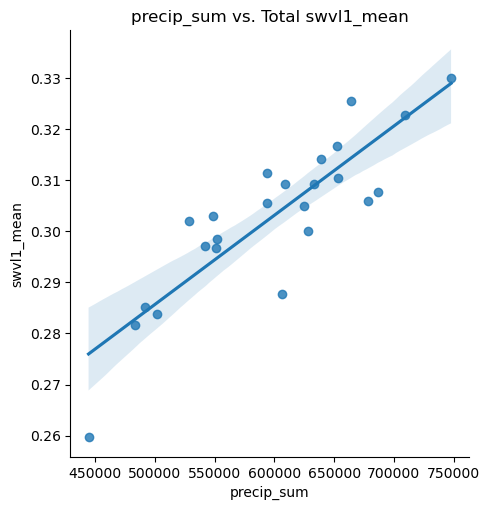

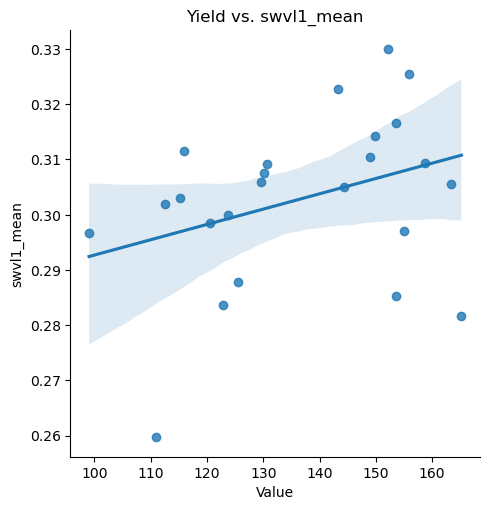

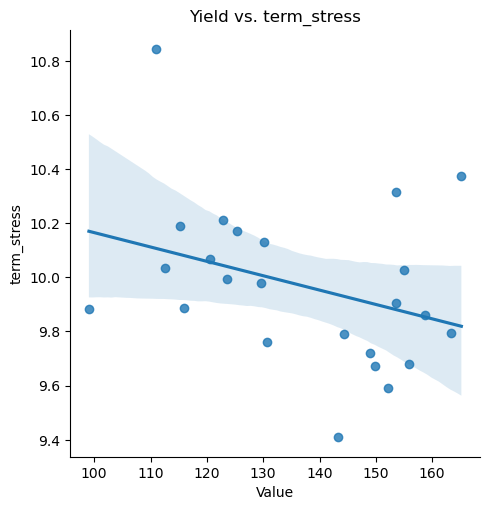

In [71]:
sns.lmplot(data=merged_df, x='precip_sum', y='swvl1_mean')
plt.title('precip_sum vs. Total swvl1_mean')
plt.show()

sns.lmplot(data=merged_df, x='Value', y='swvl1_mean')
plt.title('Yield vs. swvl1_mean')
plt.show()

sns.lmplot(data=merged_df, x='Value', y='term_stress')
plt.title('Yield vs. term_stress')
plt.show()


## Prediction

In [72]:
# Dati fino al 2023 per il training
train_df = merged_df_2[merged_df_2['year'] < 2024]

# Dati del 2024 per fare previsioni
test_df = merged_df_2[merged_df_2['year'] == 2024]

# Feature usate per il modello
features = ['swvl1_mean', 'term_stress','precip_sum']
X_train = train_df[features]
y_train = train_df['Value']
X_test = test_df[features]


In [73]:
from sklearn.ensemble import RandomForestRegressor

# Allena il modello
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [74]:
# Previsioni sul 2024
test_df['predicted_value'] = model.predict(X_test)

# Mostra i risultati per stato
result = test_df[['state_name', 'Value', 'predicted_value']]
print(result)


       state_name       Value  predicted_value
312      ILLINOIS  207.398413       116.864744
313       INDIANA  192.855556       122.835435
314          IOWA  211.356757       107.273451
315        KANSAS  133.736667       102.058251
316      KENTUCKY  160.931667       143.511287
317      MICHIGAN  164.750000       143.024988
318     MINNESOTA  170.869355       106.585987
319      MISSOURI  175.285185       107.261631
320      NEBRASKA  184.237705       100.320059
321          OHIO  165.831343       118.184978
322  SOUTH DAKOTA  154.871429       106.828014
323     TENNESSEE  133.809756       137.888915
324     WISCONSIN  161.996667       139.729728


/tmp/ipykernel_1635090/3171351504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_value'] = model.predict(X_test)


In [75]:
from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(result['Value'], result['predicted_value'])
r2 = r2_score(result['Value'], result['predicted_value'])

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


RMSE: 59.87
R² Score: -5.751


In [76]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
test_df['predicted_value'] = model.predict(X_test)


/tmp/ipykernel_1635090/4177158310.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_value'] = model.predict(X_test)


In [77]:
result = test_df[['state_name', 'Value', 'predicted_value']]
result['error'] = result['predicted_value'] - result['Value']
print(result.sort_values('error'))


       state_name       Value  predicted_value      error
314          IOWA  211.356757       113.947772 -97.408985
312      ILLINOIS  207.398413       124.867021 -82.531391
320      NEBRASKA  184.237705       102.980820 -81.256884
313       INDIANA  192.855556       125.185767 -67.669788
319      MISSOURI  175.285185       118.099116 -57.186069
318     MINNESOTA  170.869355       116.026637 -54.842717
322  SOUTH DAKOTA  154.871429       109.262765 -45.608664
317      MICHIGAN  164.750000       120.687245 -44.062755
321          OHIO  165.831343       121.904624 -43.926720
324     WISCONSIN  161.996667       122.102997 -39.893670
316      KENTUCKY  160.931667       124.604096 -36.327571
315        KANSAS  133.736667        98.140220 -35.596447
323     TENNESSEE  133.809756       123.516915 -10.292841


/tmp/ipykernel_1635090/1807765446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['error'] = result['predicted_value'] - result['Value']


In [141]:
# Creiamo la serie temporale
year_mean.set_index('year', inplace=True)
ts = year_mean[['Value']]

# Verifica
print(ts.head())

          Value
year           
1910  24.149462
1911  20.627957
1912  27.587097
1913  17.106452
1914  23.718280


In [142]:
from statsmodels.tsa.stattools import adfuller

# Test di Dickey-Fuller per la stazionarietà
result = adfuller(ts['Value'])
print(f'p-value: {result[1]}')

# Se p-value < 0.05, la serie è stazionaria
if result[1] < 0.05:
    print("La serie è stazionaria")
else:
    print("La serie non è stazionaria, bisogna differenziare")


p-value: 0.9989453166012883
La serie non è stazionaria, bisogna differenziare


In [143]:
# Differenziamo la serie per renderla stazionaria
ts['Value_diff'] = ts['Value'].diff().dropna()

# Verifica se la serie è ora stazionaria
result = adfuller(ts['Value_diff'].dropna())
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("La serie è ora stazionaria")
else:
    print("La serie non è ancora stazionaria")


p-value: 1.7181924023443488e-14
La serie è ora stazionaria


In [144]:
from pmdarima import auto_arima

# Trova automaticamente i parametri ottimali per ARIMA
model = auto_arima(ts['Value'], seasonal=False, stepwise=True, trace=True)
print(model.summary())


/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: F

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=783.598, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=822.051, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=797.885, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=779.358, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=821.996, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=781.165, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=781.097, Time=0.04 sec


/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: F

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=782.734, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=793.981, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.486 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -386.679
Date:                Wed, 30 Jul 2025   AIC                            779.358
Time:                        10:59:33   BIC                            787.566
Sample:                             0   HQIC                           782.689
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
int

/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [145]:
from statsmodels.tsa.arima.model import ARIMA

# Creiamo il modello ARIMA con i parametri ottimali
best_model = ARIMA(ts['Value'], order=model.order)
best_model_fit = best_model.fit()

# Riassunto del modello
print(best_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  115
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -394.990
Date:                Wed, 30 Jul 2025   AIC                            793.981
Time:                        10:59:37   BIC                            799.453
Sample:                             0   HQIC                           796.201
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5070      0.067     -7.560      0.000      -0.638      -0.376
sigma2        59.6893      6.716      8.887      0.000      46.525      72.853
Ljung-Box (L1) (Q):                   3.09   Jarque-

/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
# Previsione per il 2024 
forecast = best_model_fit.forecast(steps=1)

# Risultato della previsione
print(f"Previsione della resa per il 2024: {forecast}")


Previsione della resa per il 2024: 115    157.833175
dtype: float64


/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [100]:
ts = ts[ts.index > 1999][:-1]

In [107]:
print(ts.index)

Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype='int64', name='year')


In [96]:
# Aggiungi le variabili climatiche come esogene
X = merged_df[['tmax_mean', 'tmin_mean', 'precip_sum', 'swvl1_mean', 'swvl2_mean']]

In [106]:
print(X.index)

RangeIndex(start=0, stop=24, step=1)


In [110]:
X.index = pd.Index(range(2000, 2024), name='year')


In [111]:
from statsmodels.tsa.arima.model import ARIMA

# Creazione del modello ARIMAX (esogene)
model_arimax = ARIMA(ts['Value'], exog=X, order=(1, 0, 0))
model_arimax_fit = model_arimax.fit()

# Riassunto del modello
print(model_arimax_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   24
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -91.989
Date:                Wed, 30 Jul 2025   AIC                            199.977
Time:                        10:15:53   BIC                            209.402
Sample:                             0   HQIC                           202.477
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -198.7413    173.742     -1.144      0.253    -539.270     141.787
tmax_mean     -0.0675     12.059     -0.006      0.996     -23.702      23.567
tmin_mean      8.6917     14.853      0.585      0.5

/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [116]:
# Dati esogeni per il 2024
X_2024 = pd.DataFrame({
    'tmax_mean': [24.56],
    'tmin_mean': [14.19],
    'precip_sum': [483390],
    'swvl1_mean': [0.28],
    'swvl2_mean': [0.27]
}, index=[2024])

# Previsione
forecast_2024 = model_arimax_fit.forecast(steps=1, exog=X_2024)

# Output
print(f"Previsione della resa per il 2024: {forecast_2024}")

Previsione della resa per il 2024: 2024    171.060644
dtype: float64


## LSTM

In [118]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Normalizza i dati (importante per le LSTM)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts['Value'].values.reshape(-1, 1))


In [119]:
# Creazione delle sequenze temporali per LSTM
X_lstm, y_lstm = [], []
for i in range(10, len(scaled_data)):
    X_lstm.append(scaled_data[i-10:i, 0])
    y_lstm.append(scaled_data[i, 0])

In [120]:
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Ristruttura in forma (campioni, timesteps, caratteristiche)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Crea il modello LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compilazione e allenamento
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_lstm, y_lstm, epochs=10, batch_size=32)

# Previsione per il 2024 (o oltre)
predictions = model.predict(X_lstm[-1].reshape(1, X_lstm.shape[1], 1))
predicted_value = scaler.inverse_transform(predictions)
print(f"Previsione per il 2024: {predicted_value[0][0]:.2f}")


/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.5750
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.5091
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4459
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3849
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3257
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2679
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2116
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1579
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1085
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Previsione per il 2024: 157.69


In [42]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:


# --- Preparazione dei dati ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts['Value'].values.reshape(-1, 1))

# Creazione delle sequenze
def create_sequences(data, window=10):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(scaled_data, window=window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- Split train/test ---
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# --- Modello LSTM con Dropout (per MC Dropout) ---
def build_model(dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model()
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# --- Valutazione sul test set ---
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Test RMSE: {rmse:.2f}")



/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0728
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0432
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0185
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0135
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0131
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0062
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Test RMSE: 19.17


Previsione per il 2024: 149.35 ± 14.01


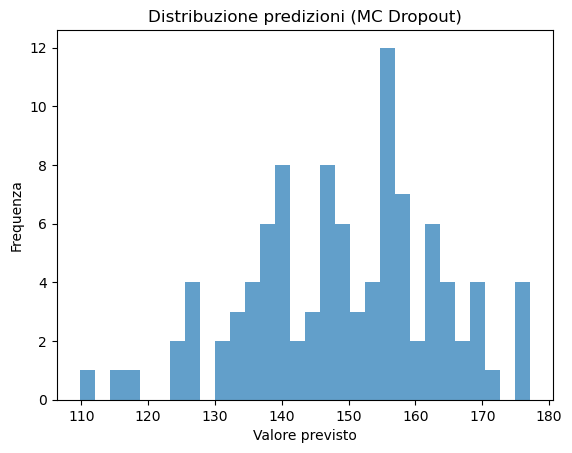

In [140]:
# --- Previsione futura con incertezza (Monte Carlo Dropout) ---
# Forza il dropout attivo anche in fase di predizione
@tf.function
def predict_with_uncertainty(f_model, X_input, n_iter=100):
    predictions = tf.stack([f_model(X_input, training=True) for _ in range(n_iter)], axis=0)
    return predictions

# Input: l'ultima finestra di dati
X_future = X[-1].reshape(1, X.shape[1], 1)
n_iter = 100
preds = predict_with_uncertainty(model, X_future, n_iter=n_iter).numpy()

# **Correzione**: Rimuovi la dimensione extra (se necessario) e riscrivi preds in formato (n_samples, 1)
preds = preds.squeeze()  # Ora la forma è (n_iter,) invece di (n_iter, 1)
preds = preds.reshape(-1, 1)  # Ora la forma è (n_iter, 1)

# Inverso della normalizzazione
preds_inv = scaler.inverse_transform(preds)  # Ora funziona senza errore
mean_pred = preds_inv.mean()
std_pred = preds_inv.std()

print(f"Previsione per il 2024: {mean_pred:.2f} ± {std_pred:.2f}")

# --- (Opzionale) Plot distribuzione ---
plt.hist(preds_inv, bins=30, alpha=0.7)
plt.title("Distribuzione predizioni (MC Dropout)")
plt.xlabel("Valore previsto")
plt.ylabel("Frequenza")
plt.show()


In [26]:
df

,year,country_name,state_name,county_name,Value
0,1910,UNITED STATES,NEBRASKA,BANNER,14.4
1,1910,UNITED STATES,NEBRASKA,BOX BUTTE,16.0
2,1910,UNITED STATES,NEBRASKA,CHEYENNE,9.6
3,1910,UNITED STATES,NEBRASKA,DAWES,16.4
4,1910,UNITED STATES,NEBRASKA,DEUEL,17.5
...,...,...,...,...,...
221552,2024,UNITED STATES,WISCONSIN,OTHER COUNTIES,167.3
221553,2024,UNITED STATES,DELAWARE,SUSSEX,204.0
221554,2024,UNITED STATES,DELAWARE,OTHER COUNTIES,217.9
221555,2024,UNITED STATES,DELAWARE,SUSSEX,105.1


In [29]:
# Exclude year 2024
df = df[df['year'] != 2024]

In [70]:
# Ensure 'date' is a datetime object
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])

# Extract year from date
hist_wx_df['year'] = hist_wx_df['date'].dt.year

# Group by AOI and year, then aggregate
yearly_agg = hist_wx_df.groupby(['aoi_id', 'adm2_name', 'adm1_name', 'year']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'sum',   # total annual precipitation
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()


In [27]:
# Exclude year 2024
yearly_agg = yearly_agg[yearly_agg['year'] != 2024]

In [32]:
yearly_agg

,aoi_id,adm2_name,adm1_name,year,tmax,tmin,precip,swvl1,swvl2
0,USA.14.100_1,Will,Illinois,2000,15.132423,6.061457,842.914769,0.326891,0.324625
1,USA.14.100_1,Will,Illinois,2001,16.011020,6.883764,878.610896,0.326762,0.323657
2,USA.14.100_1,Will,Illinois,2002,15.696758,6.754760,713.549721,0.307923,0.299384
3,USA.14.100_1,Will,Illinois,2003,15.184924,5.797577,838.731861,0.318618,0.313278
4,USA.14.100_1,Will,Illinois,2004,15.319374,6.447304,867.779170,0.330651,0.329536
...,...,...,...,...,...,...,...,...,...
23983,USA.50.9_1,Chippewa,Wisconsin,2019,10.915244,2.277480,1133.349401,0.332730,0.333087
23984,USA.50.9_1,Chippewa,Wisconsin,2020,12.487104,3.634851,788.786431,0.310643,0.310757
23985,USA.50.9_1,Chippewa,Wisconsin,2021,13.423124,4.124036,789.518562,0.315419,0.316029
23986,USA.50.9_1,Chippewa,Wisconsin,2022,11.630914,2.343184,809.045088,0.305027,0.301444


In [36]:
# First, rename adm1_name to match state_name if needed
yearly_agg.rename(columns={'adm1_name': 'state_name'}, inplace=True)
yearly_agg['state_name'] = yearly_agg['state_name'].str.upper()  # Ensure consistent casing

# Merge on year and state_name
merged_df = pd.merge(yearly_agg, df, on=['year', 'state_name'], how='inner')

/tmp/ipykernel_2126000/2178586352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_agg.rename(columns={'adm1_name': 'state_name'}, inplace=True)
/tmp/ipykernel_2126000/2178586352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_agg['state_name'] = yearly_agg['state_name'].str.upper()  # Ensure consistent casing


In [45]:
combined_df = merged_df

In [50]:
combined_df.drop(columns=['aoi_id', 'adm2_name', 'state_name', 'county_name', 'country_name'], inplace=True)


use weather

In [192]:
# Merge the datasets on the year column
combined_df = pd.merge(year_mean, year_weather_summary, on='year', how='left')

In [47]:
combined_df.fillna(0, inplace=True) 

In [57]:
combined_df


,year,tmax,tmin,precip,swvl1,swvl2,Value
0,2000,15.132423,6.061457,842.914769,0.326891,0.324625,151.0
1,2000,15.132423,6.061457,842.914769,0.326891,0.324625,150.0
2,2000,15.132423,6.061457,842.914769,0.326891,0.324625,147.0
3,2000,15.132423,6.061457,842.914769,0.326891,0.324625,137.0
4,2000,15.132423,6.061457,842.914769,0.326891,0.324625,152.0
...,...,...,...,...,...,...,...
2362628,2023,13.434391,4.751488,801.681511,0.303237,0.303790,191.5
2362629,2023,13.434391,4.751488,801.681511,0.303237,0.303790,192.4
2362630,2023,13.434391,4.751488,801.681511,0.303237,0.303790,164.4
2362631,2023,13.434391,4.751488,801.681511,0.303237,0.303790,172.4


In [52]:
# Create separate scalers
scaler_value = MinMaxScaler(feature_range=(0, 1))
scaler_weather = MinMaxScaler(feature_range=(0, 1))

# Scale the yield data and weather features separately
scaled_values = scaler_value.fit_transform(combined_df['Value'].values.reshape(-1, 1))  # Yield data
weather_features = scaler_weather.fit_transform(combined_df.drop(columns=['Value', 'year']).values)  # Weather data

# Combine scaled yield and weather features
scaled_data = np.concatenate((scaled_values, weather_features), axis=1)

In [ ]:
# 4. Create sequences with the new combined data (yield + weather)
def create_sequences_with_weather(data, window=10):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, :])  # Using both yield and weather as features
        y.append(data[i, 0])  # Target is still yield (Value column)
    return np.array(X), np.array(y)

window_size = 5
# Create sequences with the combined data
X, y = create_sequences_with_weather(scaled_data, window=window_size)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))  # Ensure proper shape

# Split the data into train and test sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [54]:
from keras.layers import Input

In [ ]:
def build_model(dropout_rate=0.2):
    model = Sequential()
    
    # Adding an Input layer explicitly
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # X_train.shape[1] = timesteps, X_train.shape[2] = features
    
    # LSTM layers with Dropout
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model()
model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=1)

# --- Valutazione sul test set ---
y_pred = model.predict(X_test)
# Inverse transform the predictions and the true values using the yield scaler (scaler_value)
y_test_inv = scaler_value.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform only the yield data
y_pred_inv = scaler_value.inverse_transform(y_pred)  # Inverse transform the predictions

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Test R²: {r2:.2f}")
print(f"Test RMSE: {rmse:.2f}")


51683/51683 ━━━━━━━━━━━━━━━━━━━━ 385s 7ms/step - loss: 0.0086
22150/22150 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step
Test RMSE: 24.26


In [113]:
# Ensure 'date' is a datetime object
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])

# Extract year from date
hist_wx_df['year'] = hist_wx_df['date'].dt.year

# Group by AOI and year, then aggregate
yearly_agg_2 = hist_wx_df.groupby(['aoi_id', 'adm2_name', 'adm1_name', 'year']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'sum',   # total annual precipitation
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()

In [114]:
year_2024 = yearly_agg_2[yearly_agg_2['year'] == 2024]

In [115]:
year_2024

,aoi_id,adm2_name,adm1_name,year,tmax,tmin,precip,swvl1,swvl2
24,USA.14.100_1,Will,Illinois,2024,9.501888,0.262948,354.730527,0.362033,0.365603
49,USA.14.101_1,Williamson,Illinois,2024,14.248563,5.014936,354.660719,0.435335,0.444246
74,USA.14.102_1,Winnebago,Illinois,2024,8.139263,-0.827421,286.902618,0.374897,0.380304
99,USA.14.103_1,Woodford,Illinois,2024,10.313823,0.510643,314.411874,0.371086,0.375993
124,USA.14.10_1,Champaign,Illinois,2024,11.419215,1.496354,342.782331,0.372219,0.376691
...,...,...,...,...,...,...,...,...,...
23888,USA.50.73_1,Winnebago,Wisconsin,2024,6.539444,-1.940882,201.217088,0.394633,0.397669
23913,USA.50.74_1,Wood,Wisconsin,2024,6.321141,-2.513175,181.617674,0.316866,0.320619
23938,USA.50.7_1,Burnett,Wisconsin,2024,5.018828,-3.507555,160.807077,0.315859,0.318037
23963,USA.50.8_1,Calumet,Wisconsin,2024,5.939550,-1.851023,192.935097,0.388606,0.391468


In [ ]:
year_2024.drop(columns=['aoi_id', 'adm2_name', 'adm1_name'], inplace=True)

/tmp/ipykernel_2126000/3061332477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_2024.drop(columns=['aoi_id', 'adm2_name', 'adm1_name'], inplace=True)


In [117]:
year_2024['Value'] = 0

/tmp/ipykernel_2126000/4066345894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_2024['Value'] = 0


In [119]:
year_2024.drop(columns='year', inplace=True)

/tmp/ipykernel_2126000/1276624268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_2024.drop(columns='year', inplace=True)


In [120]:
# 3. Scale the 2024 weather data using the same scaler used during training
scaled_values_2024 = scaler_value.transform(year_2024['Value'].values.reshape(-1, 1))  # Scale 'Value' (even though it's just 0 for prediction)
weather_features_2024 = scaler_weather.transform(year_2024.drop(columns=['Value']).values)  # Scale only weather features

# 4. Combine the scaled 'Value' and weather features (making sure to keep the same shape as training data)
scaled_data_2024 = np.concatenate((scaled_values_2024, weather_features_2024), axis=1)

# 5. Create sequences for the 2024 data using the same window size as during training
X_2024, _ = create_sequences_with_weather(scaled_data_2024, window=window_size)

# 6. Reshape X_2024 to be in the shape (samples, timesteps, features)
X_2024 = X_2024.reshape((X_2024.shape[0], X_2024.shape[1], X_2024.shape[2]))  # Shape: (samples, timesteps, features)

# 7. Predict the yield (Value) for 2024 using the trained model
y_pred_2024 = model.predict(X_2024)

# 8. Inverse transform the predictions to get the actual predicted yield values
y_pred_2024_inv = scaler_value.inverse_transform(y_pred_2024)

# Print the predicted yield values for 2024
print(f"Predicted Yield Values for 2024: {y_pred_2024_inv}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicted Yield Values for 2024: [[17.82024  ]
 [20.442825 ]
 [23.44344  ]
 [18.575857 ]
 [20.833052 ]
 [23.860415 ]
 [22.15019  ]
 [22.34537  ]
 [25.194801 ]
 [24.289211 ]
 [22.24982  ]
 [17.526503 ]
 [23.793825 ]
 [19.54744  ]
 [21.044554 ]
 [22.618652 ]
 [17.566235 ]
 [16.51241  ]
 [24.428558 ]
 [21.683771 ]
 [19.66987  ]
 [21.462807 ]
 [22.352575 ]
 [24.834454 ]
 [27.562147 ]
 [24.53721  ]
 [22.006027 ]
 [16.398788 ]
 [16.365482 ]
 [22.135118 ]
 [24.669426 ]
 [18.970701 ]
 [26.688555 ]
 [22.402878 ]
 [24.75516  ]
 [23.689482 ]
 [27.766008 ]
 [28.520105 ]
 [24.288843 ]
 [23.10237  ]
 [24.950737 ]
 [23.749228 ]
 [24.482899 ]
 [25.911776 ]
 [26.177626 ]
 [17.18739  ]
 [17.67174  ]
 [21.065662 ]
 [24.458681 ]
 [22.95417  ]
 [19.776522 ]
 [21.984198 ]
 [22.748236 ]
 [23.691961 ]
 [25.069262 ]
 [25.486126 ]
 [18.251726 ]
 [20.023233 ]
 [24.239275 ]
 [22.465836 ]
 [23.191002 ]
 [28.955189 ]
 [22.351067 ]
 [18.594679 ]
 [22.215405 ]
 [21.984499 ]
 [18

In [127]:
y_pred_2024_inv.mean()

np.float32(25.585934)

In [211]:
# --- Model Training with Validation Set ---
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0021 - val_loss: 0.0045


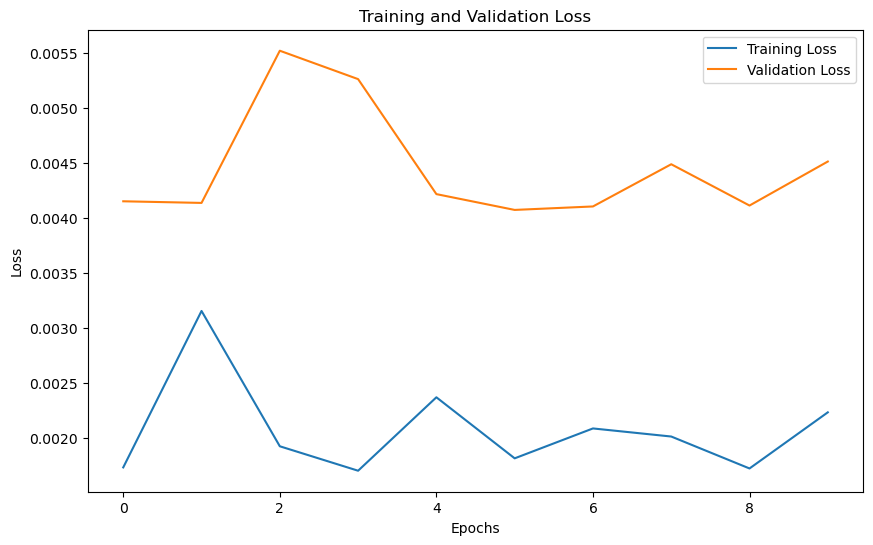

In [212]:
# Plot the training and validation loss to check for overfitting
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test RMSE: 9.72


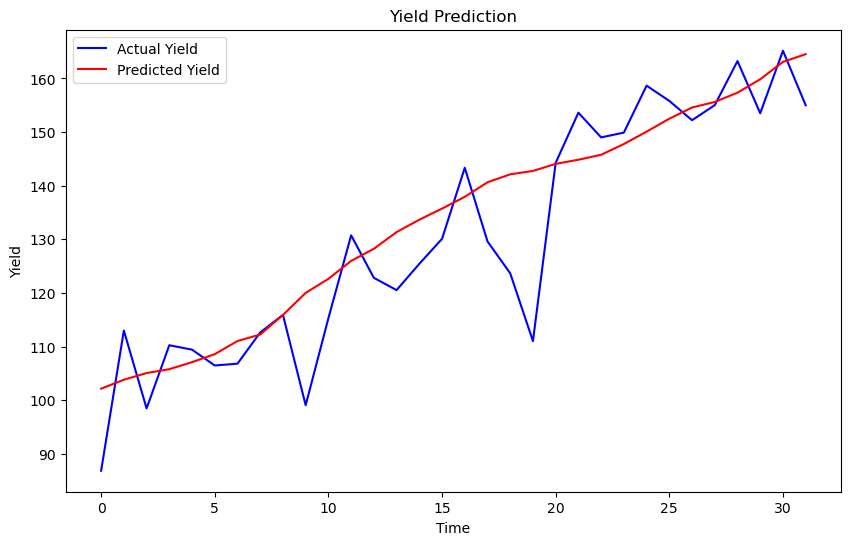

In [202]:
# --- Make predictions on the test set ---
y_pred = model.predict(X_test)

# Inverse transform the predictions and the true values using the yield scaler
y_test_inv = scaler_value.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform only the yield data
y_pred_inv = scaler_value.inverse_transform(y_pred)  # Inverse transform the predictions

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Test RMSE: {rmse:.2f}")

# --- Plot the results ---
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, color='blue', label='Actual Yield')
plt.plot(y_pred_inv, color='red', label='Predicted Yield')
plt.title('Yield Prediction')
plt.xlabel('Time')
plt.ylabel('Yield')
plt.legend()
plt.show()


Previsione per il 2024: 161.89 ± 17.56


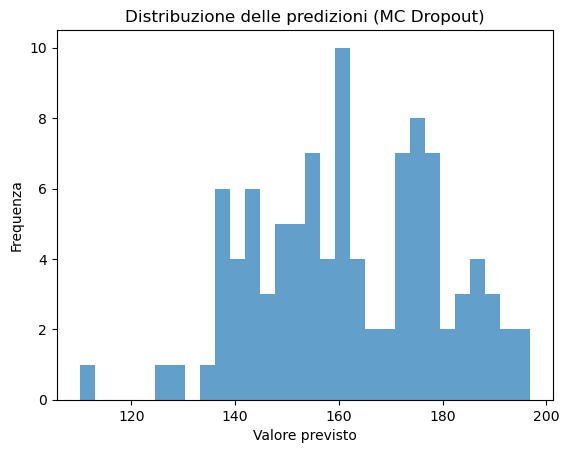

In [204]:
# --- Previsione futura con incertezza (Monte Carlo Dropout) ---
# Forza il dropout attivo anche in fase di predizione
@tf.function
def predict_with_uncertainty(f_model, X_input, n_iter=100):
    # In Monte Carlo Dropout, we predict multiple times to sample from the uncertainty.
    predictions = tf.stack([f_model(X_input, training=True) for _ in range(n_iter)], axis=0)
    return predictions

# Input: l'ultima finestra di dati (Ultimo dato della sequenza)
X_future = X[-1].reshape(1, X.shape[1], X.shape[2])  # Adjust to include all features (yield + weather)
n_iter = 100  # Number of iterations for Monte Carlo Dropout

# Get predictions with uncertainty
preds = predict_with_uncertainty(model, X_future, n_iter=n_iter).numpy()

# Remove extra dimension, if necessary, and reshape predictions
preds = preds.squeeze()  # Shape will be (n_iter,) instead of (n_iter, 1)
preds = preds.reshape(-1, 1)  # Now shape is (n_iter, 1) for consistency

# --- Inverso della normalizzazione ---
# Inverse transform the predictions using the scaler for yield data (scaler_value)
preds_inv = scaler_value.inverse_transform(preds)  # Inverse transform the predictions

# Calculate the mean and standard deviation (uncertainty) of the predictions
mean_pred = preds_inv.mean()
std_pred = preds_inv.std()

print(f"Previsione per il 2024: {mean_pred:.2f} ± {std_pred:.2f}")

# --- (Opzionale) Plot della distribuzione delle predizioni ---
plt.hist(preds_inv, bins=30, alpha=0.7)
plt.title("Distribuzione delle predizioni (MC Dropout)")
plt.xlabel("Valore previsto")
plt.ylabel("Frequenza")
plt.show()

## RandomForestRegressor

In [149]:
county_yield = df.groupby(['county_name', 'year'])['Value'].mean().reset_index()

In [153]:
# Ensure 'date' is a datetime object
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])

# Extract year from date
hist_wx_df['year'] = hist_wx_df['date'].dt.year

# Group by AOI and year, then aggregate
weather_year_county_agg = hist_wx_df.groupby(['adm2_name', 'year']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'sum',   # total annual precipitation
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()

In [154]:
weather_year_county_agg['adm2_name'] = weather_year_county_agg['adm2_name'].str.upper()  # Ensure consistent casing

In [195]:
df_county = weather_year_county_agg.merge(county_yield, left_on=['adm2_name', 'year'], right_on=['county_name', 'year'], how='inner')


In [212]:
df_county.drop(columns=['adm2_name'], inplace=True)

In [ ]:
year_2024.rename(columns={'adm2_name': 'county_name'}, inplace=True)
# Ensure 'date' is a datetime object
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])

# Extract year from date
hist_wx_df['year'] = hist_wx_df['date'].dt.year

# Group by AOI and year, then aggregate
yearly_agg_2 = hist_wx_df.groupby(['aoi_id', 'adm2_name', 'adm1_name', 'year']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'mean',   # total annual precipitation
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()

year_2024 = yearly_agg_2[yearly_agg_2['year'] == 2024]
year_2024
year_2024.drop(columns=['aoi_id', 'adm1_name'], inplace=True)

In [229]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

# Load your data
data = df_county

# Data Preprocessing
# Handle missing values and categorical columns
X = data.drop(columns=['Value'])
y = data['Value']

# List categorical columns to be one-hot encoded or label encoded
categorical_columns = ['county_name', 'year']  # Adjust based on actual categorical columns

# List continuous columns to be scaled
numerical_columns = ['tmax', 'tmin', 'precip', 'swvl1', 'swvl2']

# Create the preprocessing pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())  # Scale numerical features
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical data
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

# Combine pipelines into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

# Model pipeline with a Random Forest Regressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # You can experiment with other models
])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Mean Absolute Error: 15.375402487264118
Mean Squared Error: 427.98919670532865
R-squared: 0.6408916835589797


In [230]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Fit Random Forest
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf.fit(X_train, y_train)

# Get prediction from each tree
model = rf.named_steps['model']
X_2024_transformed = rf.named_steps['preprocessor'].transform(year_2024)

tree_preds = np.array([tree.predict(X_2024_transformed) for tree in model.estimators_])
mean_pred = tree_preds.mean()
std_pred = tree_preds.std()

print(f"2024 Prediction (Random Forest): {mean_pred:.2f} ± {std_pred:.2f} bu/acre")


2024 Prediction (Random Forest): 110.90 ± 34.64 bu/acre


 Linear Regression
Linear Regression is a simple, interpretable model that assumes a linear relationship between the input features and the target variable.

In [234]:
from sklearn.linear_model import LinearRegression

# Using Linear Regression instead of Random Forest
linear_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # Linear Regression Model
])

# Train the model
linear_model_pipeline.fit(X_train, y_train)

# Predictions
y_pred_linear = linear_model_pipeline.predict(X_test)

# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f'Linear Regression - Mean Absolute Error: {mae_linear}')
print(f'Linear Regression - Mean Squared Error: {mse_linear}')
print(f'Linear Regression - R-squared: {r2_linear}')


Linear Regression - Mean Absolute Error: 13.870438473112582
Linear Regression - Mean Squared Error: 343.7954307191622
Linear Regression - R-squared: 0.7115352460387545


In [236]:
import statsmodels.api as sm

# Preprocess training data
X_design = preprocessor.fit_transform(X_train)

# Convert to dense array if it's sparse
if hasattr(X_design, "toarray"):
    X_design = X_design.toarray()

# Add intercept
X_design = sm.add_constant(X_design)

# Fit statsmodels OLS
ols_model = sm.OLS(y_train, X_design).fit()

# Preprocess 2024 input
X_2024 = preprocessor.transform(year_2024)

# Convert to dense if sparse
if hasattr(X_2024, "toarray"):
    X_2024 = X_2024.toarray()

# Add intercept
X_2024 = sm.add_constant(X_2024)

# Prediction with confidence interval
pred_2024 = ols_model.get_prediction(X_2024)
summary_frame = pred_2024.summary_frame(alpha=0.05)

point = summary_frame["mean"].values[0]
ci_lower = summary_frame["obs_ci_lower"].values[0]
ci_upper = summary_frame["obs_ci_upper"].values[0]

print(f"2024 Prediction (OLS): {point:.2f} bu/acre, 95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")



2024 Prediction (OLS): 120.02 bu/acre, 95% CI: [85.02, 155.03]


XGBoost
XGBoost (Extreme Gradient Boosting) is a highly optimized implementation of gradient boosting that often yields high performance and efficiency.

In [202]:
import xgboost as xgb

# Using XGBoost Regressor
xgb_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(n_estimators=100, random_state=42))  # XGBoost Regressor
])

# Train the model
xgb_model_pipeline.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model_pipeline.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Mean Absolute Error: {mae_xgb}')
print(f'XGBoost - Mean Squared Error: {mse_xgb}')
print(f'XGBoost - R-squared: {r2_xgb}')


XGBoost - Mean Absolute Error: 15.017788414417922
XGBoost - Mean Squared Error: 389.6806781956782
XGBoost - R-squared: 0.6730348023415361


 Support Vector Regression (SVR)
Support Vector Regression (SVR) is a version of Support Vector Machines (SVM) for regression tasks. It works by finding a hyperplane that best fits the data in a high-dimensional space.

In [237]:
from sklearn.svm import SVR

# Pipeline con Support Vector Regression
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='rbf', C=100, epsilon=0.1))  # puoi modificare i parametri
])

# Training
svr_pipeline.fit(X_train, y_train)

# Predizioni
y_pred_svr = svr_pipeline.predict(X_test)

# Valutazione
print("=== Support Vector Regression ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_svr)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_svr)}")
print(f"R²: {r2_score(y_test, y_pred_svr)}")


=== Support Vector Regression ===
MAE: 12.379936484713035
MSE: 281.7350381635797
R²: 0.763607595667823


In [239]:
import numpy as np
from sklearn.utils import resample
n_bootstraps = 10
predictions = []

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)

    # Fit model (use e.g. SVR or ElasticNet)
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', SVR())  # or ElasticNet()
    ])
    model.fit(X_resampled, y_resampled)

    # Predict 2024
    pred = model.predict(year_2024)[0]  # Assuming 1-row input
    predictions.append(pred)

predictions = np.array(predictions)
mean_prediction = predictions.mean()
std_prediction = predictions.std()

print(f"2024 Yield Prediction: {mean_prediction:.2f} ± {std_prediction:.2f} bu/acre")


2024 Yield Prediction: 127.62 ± 1.09 bu/acre


ElasticNet (Regularized Linear Model)
ElasticNet combines L1 (Lasso) and L2 (Ridge) regularization, which can help improve the model's generalization when there is multicollinearity in the data.

In [ ]:
from sklearn.linear_model import ElasticNet

# Pipeline con ElasticNet
elastic_net_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42))  
])

# Training
elastic_net_pipeline.fit(X_train, y_train)

# Predizioni
y_pred_en = elastic_net_pipeline.predict(X_test)

# Valutazione
print("=== ElasticNet Regression ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_en)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_en)}")
print(f"R²: {r2_score(y_test, y_pred_en)}")


=== ElasticNet Regression ===
MAE: 14.56148487035646
MSE: 376.05202388119534
R²: 0.6844700515111553


/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.816e+05, tolerance: 1.228e+03
  model = cd_fast.sparse_enet_coordinate_descent(


In [ ]:
import numpy as np
from sklearn.utils import resample
n_bootstraps = 50
predictions = []

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)

    # Fit model 
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', ElasticNet())  # or ElasticNet()
    ])
    model.fit(X_resampled, y_resampled)

    # Predict 2024
    pred = model.predict(year_2024)[0]  # Assuming 1-row input
    predictions.append(pred)

predictions = np.array(predictions)
mean_prediction = predictions.mean()
std_prediction = predictions.std()

print(f"2024 Yield Prediction: {mean_prediction:.2f} ± {std_prediction:.2f} bu/acre")

2024 Yield Prediction: 153.07 ± 0.74 bu/acre
